# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [7]:
#Create a training batch
IMAGES_PATH = os.path.join('data','train','images')
number_images = 30
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:
#Create a validation batch
IMAGES_PATH = os.path.join('data','val','images')
number_images = 15
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [5]:
#Create a testing batch
IMAGES_PATH = os.path.join('data','test','images')
number_images = 15
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [8]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [9]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [12]:
images = tf.data.Dataset.list_files('data\\train\\images\\*.jpg',shuffle=False)

In [13]:
images.as_numpy_iterator().next()

b'data\\train\\images\\.ipynb_checkpoints\\30e1e43b-5cfa-11ed-97ac-b42e99c695f0-checkpoint.jpg'

In [14]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
images = images.map(load_image)

In [16]:
images.as_numpy_iterator().next()

array([[[  3,  40,  23],
        [  2,  38,  24],
        [  0,  37,  26],
        ...,
        [151, 199, 235],
        [161, 206, 247],
        [156, 199, 241]],

       [[  4,  41,  23],
        [  4,  43,  25],
        [  1,  39,  26],
        ...,
        [153, 203, 238],
        [165, 210, 251],
        [160, 203, 245]],

       [[  0,  36,  15],
        [  0,  42,  22],
        [  0,  40,  22],
        ...,
        [155, 205, 240],
        [164, 209, 250],
        [159, 204, 245]],

       ...,

       [[  7,  90,  96],
        [  2,  85,  91],
        [  1,  84,  90],
        ...,
        [ 73,  93, 100],
        [ 73,  93, 100],
        [ 75,  95, 102]],

       [[  5,  90,  95],
        [  1,  86,  91],
        [  1,  86,  91],
        ...,
        [ 68,  91,  99],
        [ 65,  88,  96],
        [ 64,  87,  95]],

       [[  4,  92,  96],
        [  2,  90,  94],
        [  5,  90,  95],
        ...,
        [ 66,  91,  98],
        [ 62,  85,  93],
        [ 58,  81,  89]]

In [17]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [28]:
plot_images = image_generator.next()

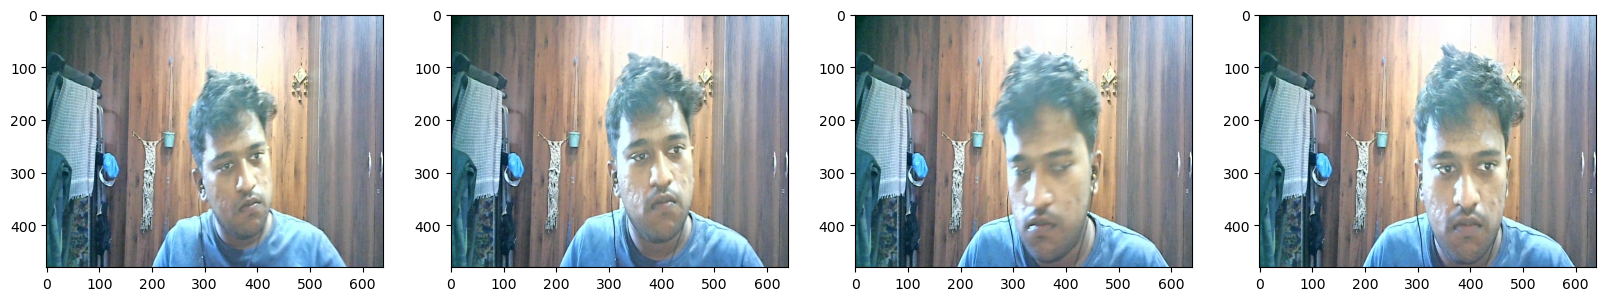

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()
#Image size is 640x480 

# 4. Apply Image Augmentation on Images and Labels using Albumentations


### 4.1 Setup Albumentations Transform Pipeline

In [30]:
import albumentations as alb

In [32]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [33]:
img = cv2.imread(os.path.join('data','train', 'images','30e1e43b-5cfa-11ed-97ac-b42e99c695f0.jpg'))

In [34]:
img

array([[[ 23,  40,   3],
        [ 25,  39,   3],
        [ 27,  37,   1],
        ...,
        [238, 200, 152],
        [248, 206, 163],
        [242, 200, 158]],

       [[ 25,  42,   5],
        [ 26,  43,   6],
        [ 26,  38,   2],
        ...,
        [240, 202, 154],
        [251, 209, 166],
        [245, 203, 160]],

       [[ 17,  36,   0],
        [ 22,  41,   2],
        [ 23,  41,   2],
        ...,
        [242, 205, 155],
        [251, 210, 165],
        [246, 205, 160]],

       ...,

       [[ 97,  90,  10],
        [ 92,  85,   5],
        [ 91,  84,   4],
        ...,
        [101,  94,  75],
        [101,  94,  75],
        [102,  95,  76]],

       [[ 96,  90,   7],
        [ 92,  86,   3],
        [ 94,  86,   3],
        ...,
        [ 99,  90,  70],
        [ 97,  88,  68],
        [ 96,  87,  67]],

       [[ 98,  93,   8],
        [ 95,  90,   5],
        [ 98,  90,   7],
        ...,
        [ 98,  90,  67],
        [ 95,  84,  64],
        [ 91,  80,  60]]

In [43]:
img.shape

(480, 640, 3)

In [35]:
with open(os.path.join('data', 'train', 'labels', '30e1e43b-5cfa-11ed-97ac-b42e99c695f0.json'), 'r') as f:
    label = json.load(f)

In [38]:
label['shapes'][0]

{'label': 'face',
 'points': [[334.795918367347, 66.02040816326533],
  [520.5102040816327, 429.2857142857142]],
 'group_id': None,
 'shape_type': 'rectangle',
 'flags': {}}

In [41]:
label['shapes'][0]['points']

[[334.795918367347, 66.02040816326533], [520.5102040816327, 429.2857142857142]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [39]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [42]:
coords #Should be the same as points

[334.795918367347, 66.02040816326533, 520.5102040816327, 429.2857142857142]

In [44]:
coords = list(np.divide(coords, [640,480,640,480]))

In [45]:
coords

[0.5231186224489797,
 0.13754251700680278,
 0.8132971938775511,
 0.8943452380952379]

### 4.4 Apply Augmentations and View Results

In [46]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [51]:
augmented['bboxes'][0]

(0.0, 0.08603174603174613, 0.36712018140589564, 0.8932879818594104)

In [53]:
augmented['bboxes']
#Values here signify x_min, y_min,x_max,y_max in this order

[(0.0, 0.08603174603174613, 0.36712018140589564, 0.8932879818594104)]

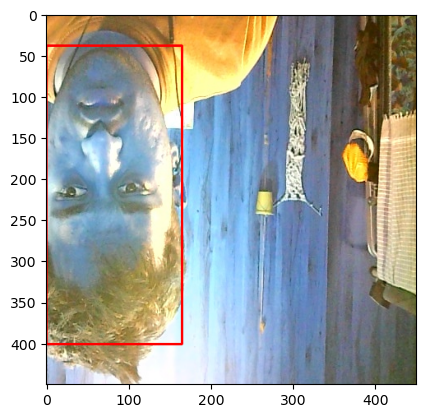

In [54]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [61]:
image='30e1e43b-5cfa-11ed-97ac-b42e99c695f0.jpg'
label_path = os.path.join('data', 'train', 'labels', f'{image.split(".")[0]}.json')
label_path

'data\\train\\labels\\30e1e43b-5cfa-11ed-97ac-b42e99c695f0.json'

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [62]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        #We now only consider images that have a labelled face
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type


### 5.2 Load Augmented Images to Tensorflow Dataset

In [63]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [64]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [65]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [68]:
val_images.as_numpy_iterator().next()

array([[[0.09393382, 0.40281862, 0.70079654],
        [0.08443628, 0.4030637 , 0.7192402 ],
        [0.07224265, 0.40085784, 0.70851713],
        ...,
        [0.04074755, 0.24681373, 0.37279412],
        [0.        , 0.11170343, 0.23866421],
        [0.1314951 , 0.31550246, 0.39920342]],

       [[0.20159313, 0.51531863, 0.77120095],
        [0.07310049, 0.40735295, 0.7216912 ],
        [0.06231618, 0.4113358 , 0.73290443],
        ...,
        [0.10870098, 0.28474265, 0.39846814],
        [0.        , 0.07604167, 0.24589461],
        [0.13566177, 0.34577206, 0.46433824]],

       [[0.16329657, 0.4817402 , 0.74742645],
        [0.07218137, 0.4034314 , 0.740625  ],
        [0.06366421, 0.40974265, 0.7504289 ],
        ...,
        [0.1586397 , 0.29093137, 0.35955882],
        [0.01023284, 0.10398284, 0.2348652 ],
        [0.11121324, 0.31047794, 0.41311276]],

       ...,

       [[0.5230392 , 0.5098652 , 0.53125   ],
        [0.4852941 , 0.45637256, 0.48921567],
        [0.5023897 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [69]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [70]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [71]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [72]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [73]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.502 , 0.1045, 0.9146, 0.9116], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [74]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 900, 900, 900, 900)

### 7.2 Create Final Datasets (Images/Labels)

In [75]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [76]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [77]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [78]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1227 , 0.1927 , 0.517  , 0.9204 ],
        [0.3665 , 0.05203, 0.7476 , 0.7593 ],
        [0.2942 , 0.05493, 0.6753 , 0.7397 ],
        [0.0834 , 0.07965, 0.3918 , 0.6826 ],
        [0.0783 , 0.2942 , 0.4185 , 0.9497 ],
        [0.397  , 0.0772 , 0.7505 , 0.71   ],
        [0.     , 0.     , 0.3972 , 0.7056 ],
        [0.4026 , 0.06744, 0.8154 , 0.841  ]], dtype=float16))

### 7.3 View Images and Annotations

In [79]:
data_samples = train.as_numpy_iterator()

In [84]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


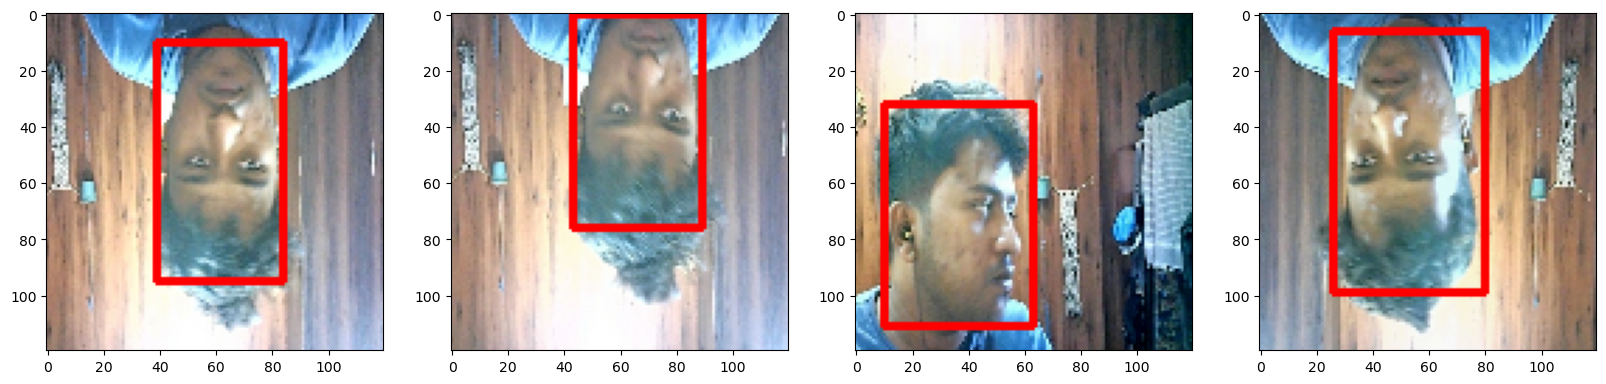

In [85]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [86]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [87]:
vgg = VGG16(include_top=False)

58892288/58889256 [==============================] - 8s 0us/step


In [88]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [90]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [91]:
facetracker = build_model()

In [92]:
facetracker.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
_______________________________________________________________________________________

In [93]:
X, y = train.as_numpy_iterator().next()

In [94]:
X.shape

(8, 120, 120, 3)

In [95]:
classes, coords = facetracker.predict(X)

In [96]:
classes, coords

(array([[0.54023075],
        [0.57375205],
        [0.62161165],
        [0.591723  ],
        [0.50290006],
        [0.5026719 ],
        [0.5142023 ],
        [0.61601436]], dtype=float32),
 array([[0.72863954, 0.3925746 , 0.64310837, 0.77606696],
        [0.7051358 , 0.32582018, 0.52152747, 0.75878316],
        [0.6957105 , 0.3435401 , 0.5481563 , 0.74743074],
        [0.67798436, 0.3425206 , 0.49077517, 0.7078653 ],
        [0.7466938 , 0.377445  , 0.6151047 , 0.7400526 ],
        [0.7364506 , 0.34723136, 0.5691363 , 0.6914424 ],
        [0.75990987, 0.34251615, 0.61911386, 0.7452806 ],
        [0.6488285 , 0.33528274, 0.6290598 , 0.7522025 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [97]:
#Slow down Learning rate with a decay function to reduce overfit
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [98]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [100]:
#Compute the binding box coords and other information
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [101]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics( We need 2 loss functions for 2 potential outputs)

In [102]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.5156965>

In [103]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5870346>

In [104]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.5156965>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [105]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [106]:
model = FaceTracker(facetracker)

In [107]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [108]:
logdir='logs'

In [109]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [111]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
450/450 [==============================] - 35s 77ms/step - total_loss: 0.0023 - class_loss: 4.0045e-08 - regress_loss: 0.0023 - val_total_loss: 0.0339 - val_class_loss: 2.9802e-08 - val_regress_loss: 0.0339
Epoch 2/30
450/450 [==============================] - 34s 76ms/step - total_loss: 0.0021 - class_loss: 3.3239e-08 - regress_loss: 0.0021 - val_total_loss: 0.0367 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0367
Epoch 3/30
450/450 [==============================] - 34s 76ms/step - total_loss: 0.0019 - class_loss: 2.6796e-08 - regress_loss: 0.0019 - val_total_loss: 0.0410 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0410
Epoch 4/30
450/450 [==============================] - 34s 75ms/step - total_loss: 0.0020 - class_loss: 2.3921e-08 - regress_loss: 0.0020 - val_total_loss: 0.0225 - val_class_loss: 2.9802e-08 - val_regress_loss: 0.0225
Epoch 5/30
450/450 [==============================] - 34s 75ms/step - total_loss: 0.0016 - class_loss: 1.6685e-08 - regress_loss

### 10.3 Plot Performance

In [112]:
hist.history

{'total_loss': [0.001854961272329092,
  0.0021185697987675667,
  0.0011698948219418526,
  0.0020265853963792324,
  0.002187909558415413,
  0.0014053493505343795,
  0.0011451118625700474,
  0.000794503721408546,
  0.002134955022484064,
  0.0006357772508636117,
  0.0008079950930550694,
  0.000943101302254945,
  0.0009936837013810873,
  0.0005753567675128579,
  0.0009300786769017577,
  0.0010001151822507381,
  0.0007150197634473443,
  0.0007148073054850101,
  0.0006898324354551733,
  0.0004331809759605676,
  0.0003640244249254465,
  0.0002270989934913814,
  0.00037556170718744397,
  0.00019444510689936578,
  0.0003191028954461217,
  0.0003229422145523131,
  0.00025219962117262185,
  0.0002386607666267082,
  0.00035835368908010423,
  0.000510566751472652],
 'class_loss': [2.980232594040899e-08,
  1.4901162970204496e-08,
  -0.0,
  -0.0,
  1.4901162970204496e-08,
  1.4901162970204496e-08,
  1.4901162970204496e-08,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  1.4901162970204496e-08,
  -0.0,
  -0.0,
  -0

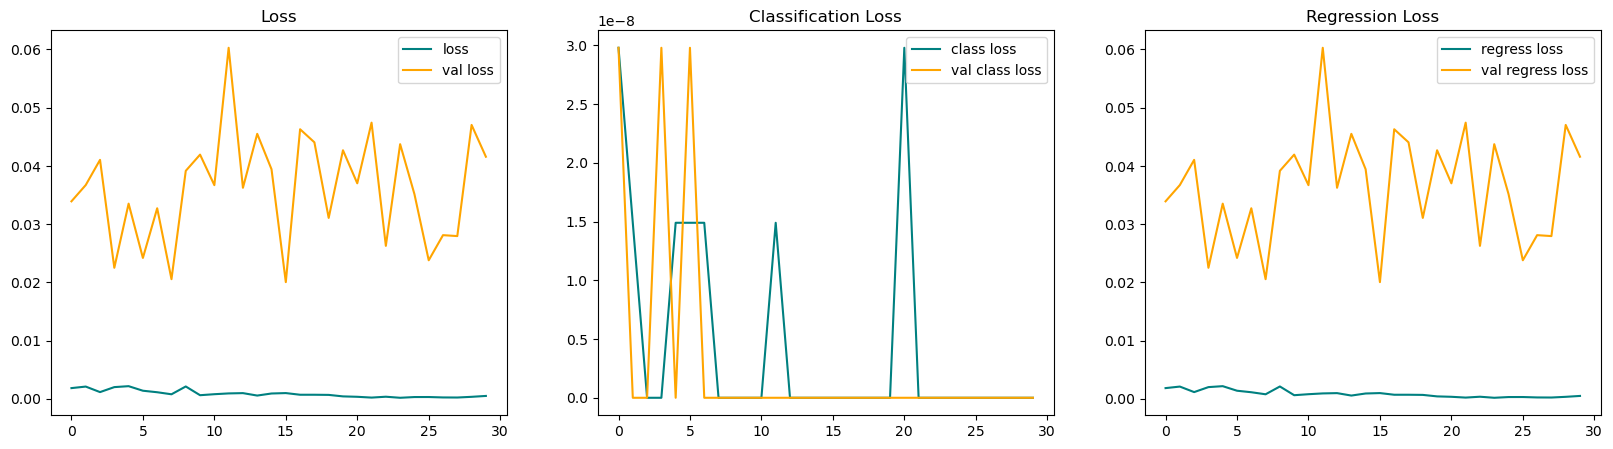

In [113]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [114]:
test_data = test.as_numpy_iterator()

In [115]:
test_sample = test_data.next()

In [116]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


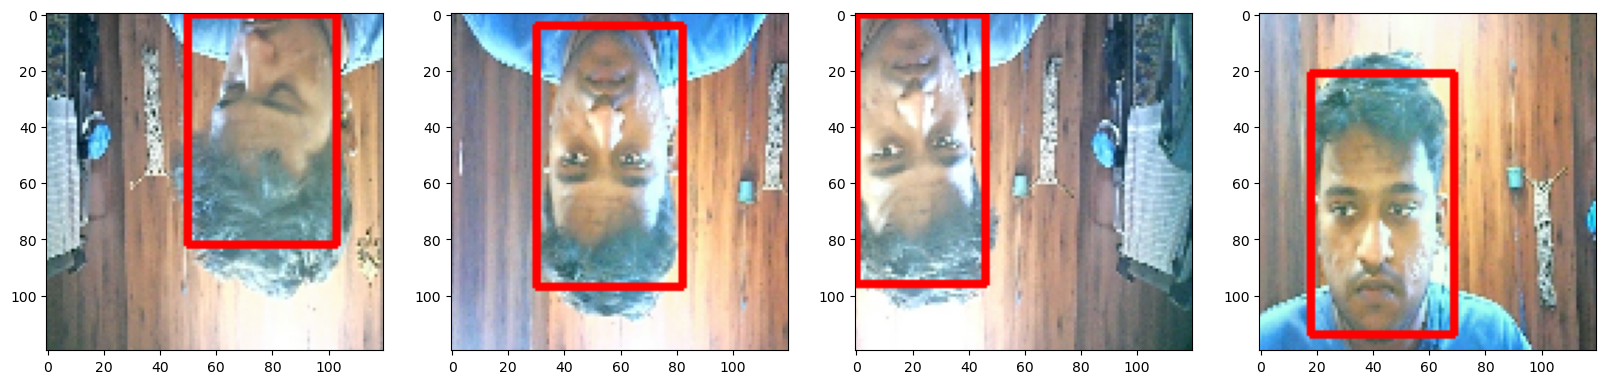

In [117]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [118]:
from tensorflow.keras.models import load_model

In [119]:
facetracker.save('facetracker.h5')

In [120]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [121]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),2
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()